In [1]:
# === SETUP ===
import sys, platform, math, random, json, numpy as np, pandas as pd
from datetime import datetime, timedelta
from dateutil import parser as dparse
import numpy as np
from numpy.lib.stride_tricks import as_strided
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gc
import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

np.random.seed(7); tf.random.set_seed(7)

print("[SETUP] pandas", pd.__version__, "| tf", tf.__version__, "| transformers", pipeline.__module__.split('.')[0])



C:\Users\Ishaan Chaturvedi\anaconda3\envs\tfchat-220\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[SETUP] pandas 2.3.1 | tf 2.19.1 | transformers transformers


In [2]:
print("Devices:", tf.config.list_physical_devices())
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision on")
except Exception as e:
    print("Mixed precision not enabled:", e)
try:
    tf.config.optimizer.set_jit(True)
    print("XLA JIT on")
except Exception as e:
    print("XLA JIT not enabled:", e)

Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Mixed precision on
XLA JIT on


In [3]:
# === DATA SOURCES ===
STOOQ = "https://stooq.com/q/d/l/?s=aapl.us&i=d"  # AAPL daily
SEC_CF = "https://data.sec.gov/api/xbrl/companyfacts/CIK0000320193.json"
SEC_HEADERS = {"User-Agent": "YourName YourEmail"}  # use a real UA per SEC rules
GDELT = "https://api.gdeltproject.org/api/v2/doc/doc"  # we'll pass params

DOMS = ["domainis:morningbrew.com","domainis:wsj.com","domainis:bloomberg.com"]  # optional
query = "(" + " OR ".join(DOMS) + ") (Apple OR AAPL)"

# === FETCH PRICES ===
px = pd.read_csv(STOOQ)
px["Date"] = pd.to_datetime(px["Date"], errors="coerce")
px = px.sort_values("Date").set_index("Date").asfreq("B").ffill()

print("[DATA] px", px.shape, "| dates", px.index.min().date(), "→", px.index.max().date())

# === FETCH FUNDAMENTALS ===
try:
    j = requests.get(SEC_CF, headers=SEC_HEADERS, timeout=30).json()
    rows = []
    for tag in ['Revenues','NetIncomeLoss','EarningsPerShareDiluted','AssetsCurrent','LiabilitiesCurrent']:
        arr = j.get('facts',{}).get('us-gaap',{}).get(tag,{}).get('units',{})
        arr = arr.get('USD') or next(iter(arr.values()), [])
        for z in arr:
            if 'end' in z:
                rows.append({"Date": dparse.parse(z['end']).date(), "tag": tag, "val": z.get('val', np.nan)})
    fund = pd.DataFrame(rows)
    fund['Date'] = pd.to_datetime(fund['Date'])
    fund = fund.pivot_table(index='Date', columns='tag', values='val', aggfunc='last').sort_index()
except Exception as e:
    print("[DATA][SEC] error:", e)
    fund = pd.DataFrame(index=px.index)

fund = fund.asfreq('B')
fund = fund.reindex(px.index).ffill()

print("[DATA] fund", fund.shape, "| NaN cols:", fund.columns[fund.isna().all()].tolist())

# === FETCH NEWS (GDELT) ===
try:
    r = requests.get(GDELT, params={"query":query, "mode":"artlist", "format":"json", "maxrecords":"250", "timespan":"3m"}, timeout=30)
    arts = r.json().get('articles', [])
except Exception as e:
    print("[DATA][GDELT] error:", e); arts = []

print("[DATA] articles:", len(arts))


[DATA] px (10686, 5) | dates 1984-09-07 → 2025-08-22
[DATA] fund (10686, 5) | NaN cols: ['AssetsCurrent', 'EarningsPerShareDiluted', 'LiabilitiesCurrent', 'NetIncomeLoss', 'Revenues']
[DATA] articles: 25


In [4]:
# === SENTIMENT ===
try:
    tok = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    mdl = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    sentpipe = pipeline("text-classification", model=mdl, tokenizer=tok, top_k=None)  # <- FIX for deprecation
except Exception as e:
    print("[SENT] model load error:", e); sentpipe = None

recs = []
for a in arts:
    t = (a.get('title') or '')[:220]
    if not t.strip() or sentpipe is None:
        continue
    ts = a.get('seendate') or a.get('publishedDate') or a.get('date') or a.get('publishtime')
    try:
        d = pd.to_datetime(ts).normalize()
    except: 
        continue
    scores = {x['label'].lower(): x['score'] for x in sentpipe(t)[0]}
    recs.append({
        'Date': d, 
        'sent_pos': scores.get('positive',0.0),
        'sent_neg': scores.get('negative',0.0),
        'sent_neu': scores.get('neutral',0.0),
        'sent_score': scores.get('positive',0.0) - scores.get('negative',0.0)
    })

sent = pd.DataFrame(recs)
if len(sent):
    sent = sent.groupby('Date').mean().asfreq('B').fillna(0.0)
else:
    sent = pd.DataFrame(index=px.index, data={'sent_pos':0.0,'sent_neg':0.0,'sent_neu':0.0,'sent_score':0.0})

# optional: avoid lookahead by using info known at end of day
sent = sent.reindex(px.index).fillna(0.0).shift(1).fillna(0.0)

print("[SENT] sent", sent.shape, "| date span", sent.index.min().date(), "→", sent.index.max().date())


Device set to use cpu


[SENT] sent (10686, 4) | date span 1984-09-07 → 2025-08-22


In [5]:
# === JOIN ===
df = px.join(fund, how='left').join(sent, how='left')
if 'close' not in df.columns:
    alt = [c for c in df.columns if c.lower() == 'close']
    if alt:
        df.rename(columns={alt[0]: 'close'}, inplace=True)
    else:
        raise KeyError(f"[JOIN] Could not find a 'close' column. Available: {list(df.columns)[:20]}")

print("[JOIN] columns (first 15):", list(df.columns)[:15])
dead_cols = df.columns[df.isna().all()].tolist()
if dead_cols:
    df = df.drop(columns=dead_cols)
    print("[JOIN] dropped all-NaN cols:", dead_cols)

df = df.replace([np.inf, -np.inf], np.nan)

# === FEATURES ===
df['ret_1d']  = np.log(df['close']).diff(1)
df['ret_5d']  = np.log(df['close']).diff(5)
df['ret_10d'] = np.log(df['close']).diff(10)
df['vol_10d'] = df['ret_1d'].rolling(10).std()

df['ma_50']  = df['close'].rolling(50, min_periods=50).mean()
df['ma_100'] = df['close'].rolling(100, min_periods=100).mean()

def _rsi(x, n=14):
    g = x.clip(lower=0).rolling(n, min_periods=n).mean()
    l = (-x.clip(upper=0)).abs().rolling(n, min_periods=n).mean()
    rs = g / (l.replace(0,np.nan))
    return 100 - (100/(1+rs))

df['rsi_14'] = _rsi(df['ret_1d'], 14)

H_SHORT, H_LONG = 10, 60
df['y_short'] = np.log(df['close']).shift(+H_SHORT) - np.log(df['close'])
df['y_long']  = np.log(df['close']).shift(+H_LONG)  - np.log(df['close'])

core_cols = ['ret_1d','ret_5d','ret_10d','vol_10d','ma_50','ma_100','rsi_14','y_short','y_long','sent_score','sent_pos','sent_neg','sent_neu']
use_cols  = [c for c in core_cols if c in df.columns]  # survive dropped cols

before = df.shape[0]
df = df.dropna(subset=use_cols)  # <- FIX: drop rows only if key cols are NaN
after = df.shape[0]

print(f"[FEATS] rows before/after dropna: {before} → {after} | cols used {len(use_cols)}")
print("[FEATS] date span:", df.index.min().date(), "→", df.index.max().date())


[JOIN] columns (first 15): ['Open', 'High', 'Low', 'close', 'Volume', 'AssetsCurrent', 'EarningsPerShareDiluted', 'LiabilitiesCurrent', 'NetIncomeLoss', 'Revenues', 'sent_pos', 'sent_neg', 'sent_neu', 'sent_score']
[JOIN] dropped all-NaN cols: ['AssetsCurrent', 'EarningsPerShareDiluted', 'LiabilitiesCurrent', 'NetIncomeLoss', 'Revenues']
[FEATS] rows before/after dropna: 10686 → 10587 | cols used 13
[FEATS] date span: 1985-01-24 → 2025-08-22


In [6]:
H_1W, H_2W = 5, 10
df['y_1w'] = np.log(df['close']).shift(+H_1W) - np.log(df['close'])
df['y_2w'] = np.log(df['close']).shift(+H_2W) - np.log(df['close'])

core_cols = ['ret_1d','ret_5d','ret_10d','vol_10d','ma_50','ma_100','rsi_14',
             'sent_score','sent_pos','sent_neg','sent_neu','y_1w','y_2w']
use_cols  = [c for c in core_cols if c in df.columns]
df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=use_cols)
print("[TARGETS] rows:", len(df), "| span:", df.index.min().date(), "→", df.index.max().date())

[TARGETS] rows: 10577 | span: 1985-02-07 → 2025-08-22


In [7]:
feats = [c for c in df.columns if c not in ['y_1w','y_2w']]
n = len(df); i1 = int(0.70*n); i2 = int(0.85*n)
tr, va, te = df.iloc[:i1], df.iloc[i1:i2], df.iloc[i2:]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(tr[feats])
trX = sc.transform(tr[feats]); vaX = sc.transform(va[feats]); teX = sc.transform(te[feats])

def seq(y, M, look):
    X, Y = [], []
    for i in range(look, len(M)):
        X.append(M[i-look:i, :]); Y.append(y[i])
    return np.array(X), np.array(Y)

LOOK_1W, LOOK_2W = 120, 120
Xtr1, Ytr1 = seq(tr['y_1w'].values, trX, LOOK_1W)
Xva1, Yva1 = seq(va['y_1w'].values, vaX, LOOK_1W)
Xte1, Yte1 = seq(te['y_1w'].values, teX, LOOK_1W)

Xtr2, Ytr2 = seq(tr['y_2w'].values, trX, LOOK_2W)
Xva2, Yva2 = seq(va['y_2w'].values, vaX, LOOK_2W)
Xte2, Yte2 = seq(te['y_2w'].values, teX, LOOK_2W)

print("[SEQ] 1w:", Xtr1.shape, Xva1.shape, Xte1.shape, "| 2w:", Xtr2.shape, Xva2.shape, Xte2.shape)

[SEQ] 1w: (7283, 120, 18) (1467, 120, 18) (1467, 120, 18) | 2w: (7283, 120, 18) (1467, 120, 18) (1467, 120, 18)


In [8]:
# === LSTM (SHORT HORIZON, 1–3 WEEKS) ===
import numpy as np
from numpy.lib.stride_tricks import as_strided
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf, gc

def build_sequences(M, y, look):
    n, f = M.shape
    n_seq = n - look
    if n_seq <= 0:
        return np.empty((0, look, f)), np.empty((0,))
    s0, s1 = M.strides
    X = as_strided(M, shape=(n_seq, look, f), strides=(s0, s0, s1)).copy()
    Y = y[look:look+n_seq]
    return X, Y

def make_lstm_fast(units=96, layers_n=1, dr=0.2, lr=5e-4, look=120, nfeat=1):
    m = keras.Sequential([keras.layers.Input(shape=(look, nfeat))])
    m.add(keras.layers.LSTM(units, return_sequences=(layers_n > 1)))  # CuDNN path
    if layers_n > 1:
        m.add(keras.layers.Dropout(dr))
        m.add(keras.layers.LSTM(max(32, units // 2)))
    m.add(keras.layers.Dropout(dr))
    m.add(keras.layers.Dense(1, dtype='float32'))
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=keras.losses.Huber(), jit_compile=True)
    return m

def make_gru_fast(units=96, layers_n=1, dr=0.2, lr=5e-4, look=120, nfeat=1):
    m = keras.Sequential([keras.layers.Input(shape=(look, nfeat))])
    m.add(keras.layers.GRU(units, return_sequences=(layers_n > 1)))
    if layers_n > 1:
        m.add(keras.layers.Dropout(dr))
        m.add(keras.layers.GRU(max(32, units // 2)))
    m.add(keras.layers.Dropout(dr))
    m.add(keras.layers.Dense(1, dtype='float32'))
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=keras.losses.Huber(), jit_compile=True)
    return m

def make_cnn_fast(look=90, nfeat=1, lr=5e-4):
    inp = keras.layers.Input(shape=(look, nfeat))
    x = keras.layers.Conv1D(64, 5, padding="causal", activation="relu")(inp)
    x = keras.layers.Conv1D(64, 5, padding="causal", activation="relu")(x)
    x = keras.layers.Conv1D(64, 5, padding="causal", dilation_rate=2, activation="relu")(x)
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(0.2)(x)
    out = keras.layers.Dense(1, dtype='float32')(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(lr), loss=keras.losses.Huber(), jit_compile=True)
    return m

def train_for(name, Xtr, Ytr, Xva, Yva, Xte, Yte, maker=make_gru_fast):
    look, nfeat = int(Xtr.shape[1]), int(Xtr.shape[2])
    print(f"[{name}] look={look} nfeat={nfeat} | Xtr={Xtr.shape} Xva={Xva.shape} Xte={Xte.shape}")

    EPOCH_MAX, BATCH_SIZE = 80, 128
    PATIENCE_ES, PATIENCE_LR = 6, 3

    cands = []
    for _ in range(3):
        hp = dict(
            units=int(np.random.choice([64, 96, 128])),
            layers_n=int(np.random.choice([1, 2])),
            dr=float(np.random.choice([0.1, 0.2, 0.3])),
            lr=float(np.random.choice([1e-3, 5e-4, 3e-4]))
        )
        m = maker(hp['units'], hp['layers_n'], hp['dr'], hp['lr'], look=look, nfeat=nfeat)
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE_ES, restore_best_weights=True)
        rl = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=PATIENCE_LR, min_lr=1e-5)
        h = m.fit(Xtr, Ytr, validation_data=(Xva, Yva),
                  epochs=EPOCH_MAX, batch_size=BATCH_SIZE, verbose=0,
                  callbacks=[es, rl], shuffle=False)
        pv = m.predict(Xva, verbose=0).ravel()
        rmse = float(np.sqrt(np.mean((Yva.ravel() - pv) ** 2)))
        cands.append({**hp, 'rmse': rmse, 'model': m})
        print(f"[{name}] rmse={rmse:.6f}, epochs_run={len(h.history['loss'])}")

    best = sorted(cands, key=lambda d: d['rmse'])[0]
    model = best['model']
    preds = model.predict(Xte, verbose=0).ravel()
    rmse = float(np.sqrt(np.mean((Yte.ravel() - preds) ** 2)))
    dirac = float(np.mean((Yte.ravel() > 0) == (preds > 0)))
    print(f"[{name}] TEST rmse={rmse:.6f} dirAcc={dirac:.2%} hp={{k:v for k,v in best.items() if k!='model'}}")
    return model, preds, rmse, dirac

def walk_forward_ensemble(df, target_col, look=90,
                          train_days=900, val_days=200, test_days=180, step_days=180,
                          n_models=2, maker=make_gru_fast):
    feats = [c for c in df.columns if c not in ['y_1w', 'y_2w', target_col]]
    N = len(df)
    starts = range(0, N - (train_days + val_days + test_days), step_days)
    all_dates, all_true, all_pred, fold_metrics = [], [], [], []

    for fold, start in enumerate(starts, 1):
        tr = df.iloc[start : start + train_days]
        va = df.iloc[start + train_days : start + train_days + val_days]
        te = df.iloc[start + train_days + val_days : start + train_days + val_days + test_days]

        if min(len(tr), len(va), len(te)) <= look:
            print(f"[WF] fold {fold:02d} skipped (look too long)")
            tf.keras.backend.clear_session(); gc.collect()
            continue

        sc  = StandardScaler().fit(tr[feats])
        trX = sc.transform(tr[feats]); vaX = sc.transform(va[feats]); teX = sc.transform(te[feats])

        Xtr, Ytr = build_sequences(trX, tr[target_col].values, look)
        Xva, Yva = build_sequences(vaX, va[target_col].values, look)
        Xte, Yte = build_sequences(teX, te[target_col].values, look)

        if (len(Xtr) == 0) or (len(Xva) == 0) or (len(Xte) == 0):
            print(f"[WF] fold {fold:02d} skipped (empty sequences) | raw lens tr/va/te={len(tr)}/{len(va)}/{len(te)} look={look}")
            tf.keras.backend.clear_session(); gc.collect()
            continue

        preds_members = []
        seed_base = 1234 + start
        for m_idx in range(n_models):
            tf.keras.utils.set_random_seed(seed_base + m_idx)
            hp = dict(
                units=int(np.random.choice([64, 96, 128])),
                layers_n=int(np.random.choice([1, 2])),
                dr=float(np.random.choice([0.1, 0.2, 0.3])),
                lr=float(np.random.choice([1e-3, 5e-4, 3e-4]))
            )
            model = maker(hp['units'], hp['layers_n'], hp['dr'], hp['lr'],
                          look=look, nfeat=Xtr.shape[2])

            es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
            rl = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
            model.fit(Xtr, Ytr, validation_data=(Xva, Yva),
                      epochs=80, batch_size=128, verbose=0, callbacks=[es, rl], shuffle=False)

            preds_members.append(model.predict(Xte, verbose=0).ravel())
            del model, es, rl
            tf.keras.backend.clear_session(); gc.collect()

        pred = np.mean(preds_members, axis=0)
        rmse = float(np.sqrt(np.mean((Yte - pred) ** 2)))
        dacc = float(np.mean((Yte > 0) == (pred > 0)))
        fold_metrics.append((rmse, dacc))

        all_dates.append(np.array(te.index[look:]))
        all_true.append(Yte); all_pred.append(pred)

        print(f"[WF] fold {fold:02d} | rmse={rmse:.6f} | dirAcc={dacc:.2%} | "
              f"train:{tr.index[0].date()}→{tr.index[-1].date()} test:{te.index[0].date()}→{te.index[-1].date()}")

        del trX, vaX, teX, Xtr, Xva, Xte, Ytr, Yva, Yte
        tf.keras.backend.clear_session(); gc.collect()

    dates = np.concatenate(all_dates)
    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)
    rmse_mean = float(np.mean([r for r, _ in fold_metrics]))
    dacc_mean = float(np.mean([d for _, d in fold_metrics]))
    return {
        "dates": dates, "y_true": y_true, "y_pred": y_pred,
        "rmse_mean": rmse_mean, "diracc_mean": dacc_mean, "folds": fold_metrics
    }

LOOK = 90
res_2w = walk_forward_ensemble(
    df, target_col='y_2w', look=LOOK,
    train_days=900, val_days=200, test_days=180, step_days=180,
    n_models=2, maker=make_gru_fast
)
print("[WF][2W] mean RMSE:", res_2w['rmse_mean'], "| mean DirAcc:", f"{100*res_2w['diracc_mean']:.2f}%")

# model_1w, preds_1w, rmse_1w, dir_1w = train_for("1W", Xtr1, Ytr1, Xva1, Yva1, Xte1, Yte1, maker=make_gru_fast)
# model_2w, preds_2w, rmse_2w, dir_2w = train_for("2W", Xtr2, Ytr2, Xva2, Yva2, Xte2, Yte2, maker=make_gru_fast)


[WF] fold 01 | rmse=0.028184 | dirAcc=83.33% | train:1985-02-07→1988-07-20 test:1989-04-27→1990-01-03
[WF] fold 02 | rmse=0.038329 | dirAcc=85.56% | train:1985-10-17→1989-03-29 test:1990-01-04→1990-09-12
[WF] fold 03 | rmse=0.103730 | dirAcc=57.78% | train:1986-06-26→1989-12-06 test:1990-09-13→1991-05-22
[WF] fold 04 | rmse=0.049046 | dirAcc=75.56% | train:1987-03-05→1990-08-15 test:1991-05-23→1992-01-29
[WF] fold 05 | rmse=0.070115 | dirAcc=78.89% | train:1987-11-12→1991-04-24 test:1992-01-30→1992-10-07
[WF] fold 06 | rmse=0.039025 | dirAcc=87.78% | train:1988-07-21→1992-01-01 test:1992-10-08→1993-06-16
[WF] fold 07 | rmse=0.069497 | dirAcc=73.33% | train:1989-03-30→1992-09-09 test:1993-06-17→1994-02-23
[WF] fold 08 | rmse=0.064750 | dirAcc=81.11% | train:1989-12-07→1993-05-19 test:1994-02-24→1994-11-02
[WF] fold 09 | rmse=0.038137 | dirAcc=77.78% | train:1990-08-16→1994-01-26 test:1994-11-03→1995-07-12
[WF] fold 10 | rmse=0.049632 | dirAcc=82.22% | train:1991-04-25→1994-10-05 test:1

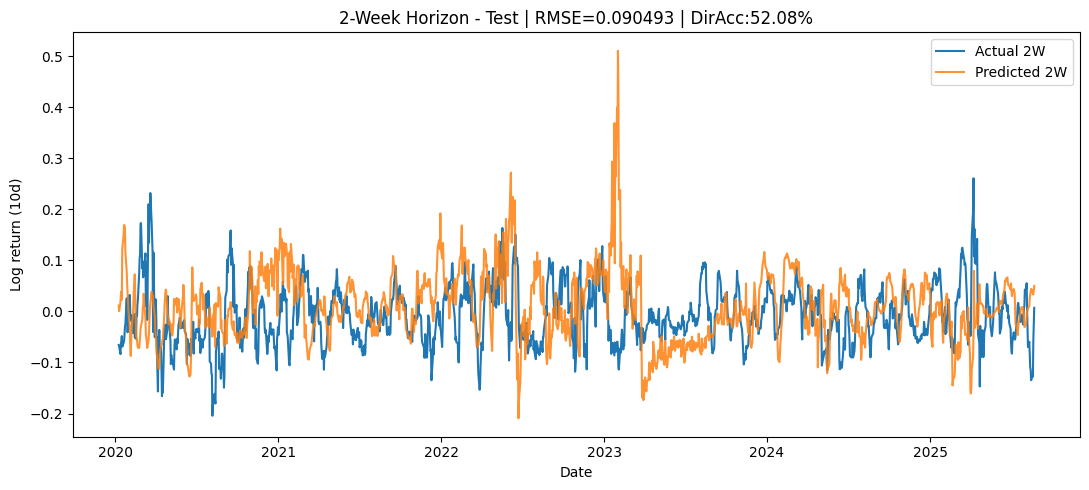

In [18]:
# graph
mask = np.isfinite(y_true) & np.isfinite(y_pred)
yt, yp = y_true[mask], y_pred[mask]

rmse_2w = float(np.sqrt(np.mean((yp - yt)**2)))
dir_2w  = float(np.mean(np.sign(yp) == np.sign(yt)))

plt.figure(figsize=(11,5))
plt.plot(dates, y_true, label="Actual 2W")
plt.plot(dates, y_pred, label="Predicted 2W", alpha=0.85)
plt.title(f"2-Week Horizon - Test | RMSE={rmse_2w:.6f} | DirAcc:{dir_2w:.2%}")
plt.xlabel("Date")
plt.ylabel("Log return (10d)")
plt.legend()
plt.tight_layout()
plt.show()